<a href="https://colab.research.google.com/github/YannisZang/cs-5805-Machine-Learning/blob/main/Linear_regression_Variants_(SOR%2C_Ridge%2C_LASSO)_NYC_Taxi_Cab_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datashader
!pip install dask

In [ ]:
# Import basic required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')
sns.set_style({'axes.grid':False})

# Advanced visualization modules(datashader)
import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import viridis, inferno

# 1. Data Loading and Basic Processing

In [ ]:
train = pd.read_csv('/content/sample_data/NYC_train_cleaned.csv')
test = pd.read_csv('/content/sample_data/NYC_test_cleaned.csv')
train.columns, test.columns, train.shape, test.shape

(Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
       dtype='object'),
 Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
       dtype='object'),
 (800000, 7),
 (200000, 7))

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], infer_datetime_format=True)
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], infer_datetime_format=True)

<ipython-input-6-eed7ee55f5b8>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], infer_datetime_format=True)
<ipython-input-6-eed7ee55f5b8>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], infer_datetime_format=True)


In [ ]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,22.5,2013-05-30 23:51:00+00:00,-73.99959,40.714508,-73.914310,40.685000,4
1,8.5,2012-09-23 10:42:49+00:00,-73.99823,40.760864,-73.989150,40.743465,1
2,14.1,2011-04-13 10:08:00+00:00,-73.99050,40.759070,-73.987946,40.761450,2
3,10.1,2012-06-05 14:44:27+00:00,-73.98430,40.761910,-73.973080,40.748734,1
4,4.1,2009-12-17 13:20:00+00:00,-73.94736,40.776060,-73.955940,40.779636,5


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 2. Data exploration

## 2.1 Fare Amount (Output variable)

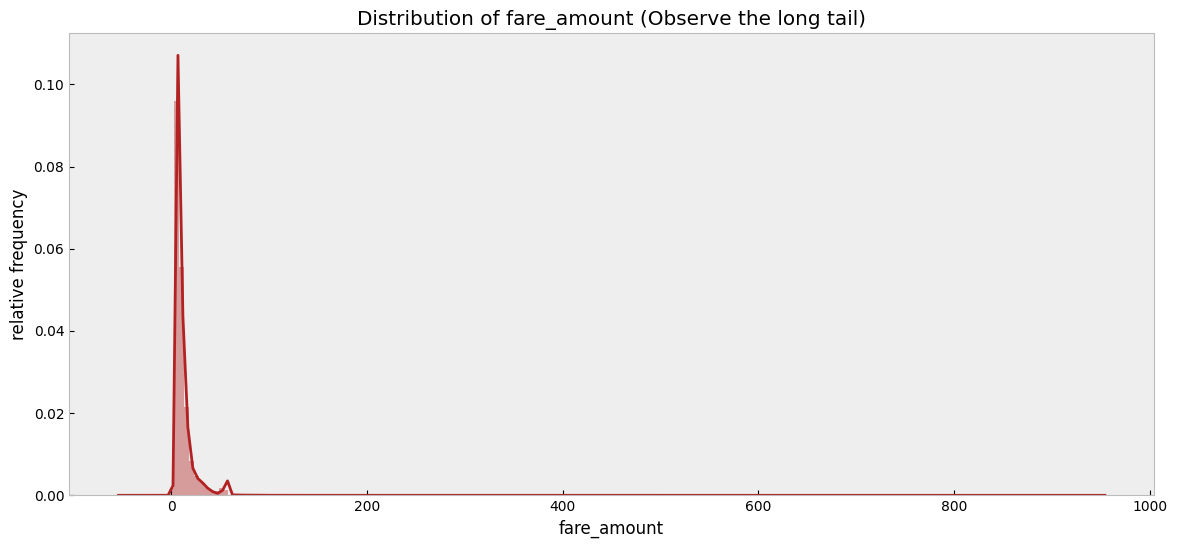

In [ ]:
fig, ax = plt.subplots(figsize = (14,6))
sns.distplot(train.fare_amount, bins = 200, color = 'firebrick', ax = ax)
ax.set_title('Distribution of fare_amount (Observe the long tail)')
ax.set_ylabel('relative frequency')
plt.show()

## 2.2 Passenger Count

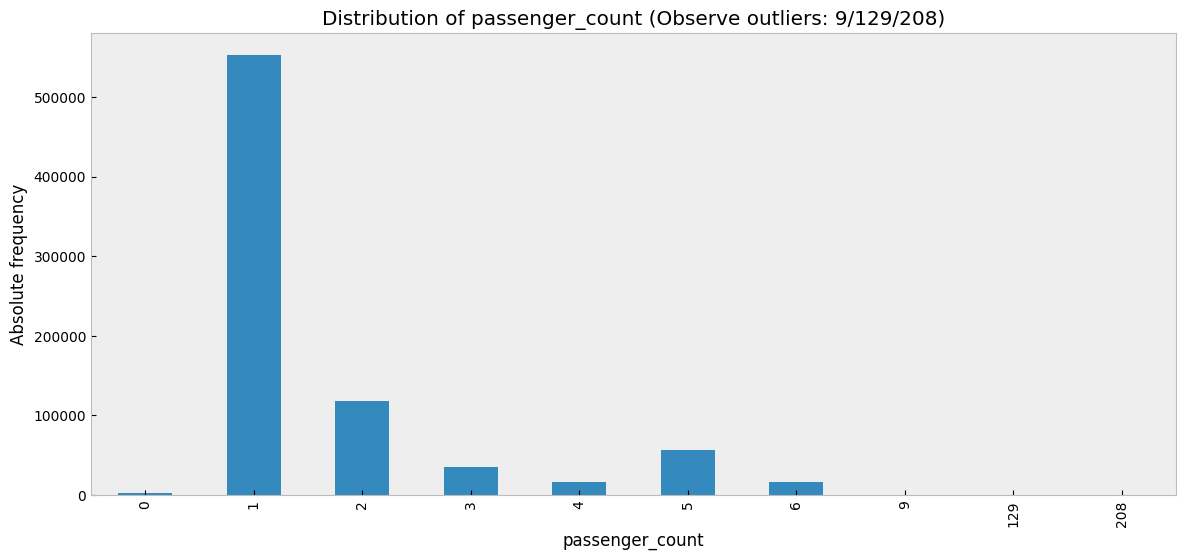

In [ ]:
fig, ax = plt.subplots(figsize = (14,6))
class_dist = train.passenger_count.value_counts()
class_dist = class_dist.sort_index()
class_dist.plot(kind = 'bar', ax = ax)
ax.set_title('Distribution of passenger_count (Observe outliers: 9/129/208)')
ax.set_ylabel('Absolute frequency')
plt.show()

# 3. Data cleaning - removing outliers

### 3.1 Removing outliers w.r.t. fare amount

In [ ]:
# Drop fare_amount less than 0.
neg_fare = train.loc[train.fare_amount<0, :].index
train.drop(neg_fare, axis = 0, inplace = True)

# Drop rows greater than 100 and lesser than 2.5
fares_to_drop = train.loc[(train.fare_amount>100) | (train.fare_amount<2.5), :].index
train.drop(fares_to_drop, axis = 0, inplace = True)
print('Shape of training data after dropping outliers: {}'.format(train.shape))

# Do the same for the test data
neg_fare = test.loc[test.fare_amount<0, :].index
test.drop(neg_fare, axis = 0, inplace = True)
fares_to_drop = test.loc[(test.fare_amount>100) | (test.fare_amount<2.5), :].index
test.drop(fares_to_drop, axis = 0, inplace = True)

Shape of training data after dropping outliers: (799636, 7)


## 3.2 Removing outliers w.r.t. latitudes and longitudes
Check the 2.5 and 97.5 percentiles of both

In [ ]:
def percentile(variable):
    two_and_half = variable.quantile(0.25)
    ninty_seven_half = variable.quantile(0.975)
    print('2.5 and 97.5 percentile of {} is respectively: {:0.2f}, and {:0.2f}'.format(variable.name, two_and_half, ninty_seven_half))

percentile(train.pickup_latitude)
percentile(train.dropoff_latitude)
percentile(train.pickup_longitude)
percentile(train.dropoff_longitude)

2.5 and 97.5 percentile of pickup_latitude is respectively: 40.73, and 40.80
2.5 and 97.5 percentile of dropoff_latitude is respectively: 40.73, and 40.81
2.5 and 97.5 percentile of pickup_longitude is respectively: -73.99, and -73.78
2.5 and 97.5 percentile of dropoff_longitude is respectively: -73.99, and -73.79


In [ ]:
train = train.loc[train.pickup_latitude.between(left = 40, right = 42), :]
train = train.loc[train.dropoff_latitude.between(left = 40, right = 42), :]

train = train.loc[train.pickup_longitude.between(left = -75, right = -72), :]
train = train.loc[train.dropoff_longitude.between(left = -75, right = -72), :]
print('Shape of training data after after dropping outliers from lats and lons: {}'.format(train.shape))

test = test.loc[test.pickup_latitude.between(left = 40, right = 42), :]
test = test.loc[test.dropoff_latitude.between(left = 40, right = 42), :]
test = test.loc[test.pickup_longitude.between(left = -75, right = -72), :]
test = test.loc[test.dropoff_longitude.between(left = -75, right = -72), :]

Shape of training data after after dropping outliers from lats and lons: (783061, 7)


### 3.3 Removing outliers w.r.t. passenger count

In [ ]:
passenger_count_to_drop = train.loc[(train.passenger_count > 6)].index
train.drop(passenger_count_to_drop, axis = 0, inplace = True)
print('Shape of training data after dropping outliers w.r.t. passenger_count:{}'.format(train.shape))

passenger_count_to_drop = test.loc[(test.passenger_count > 6)].index
test.drop(passenger_count_to_drop, axis = 0, inplace = True)

display(train.passenger_count.describe())

Shape of training data after dropping outliers w.r.t. passenger_count:(783061, 7)


,passenger_count
count,783061.000000
mean,1.686926
std,1.309967
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,6.000000


# 4. Feature Engineering

In [ ]:
merged = pd.concat([train,test], axis = 0, sort=False)

## 4.1 Great circle distance using haversine formula

In [ ]:
def great_circle_distance(lon1,lat1,lon2,lat2):
    R = 6371000 # Approximate mean radius of earth (in m)

    # Convert decimal degrees to ridians
    lon1,lat1,lon2,lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Distance of lons and lats in radians
    dis_lon = lon2 - lon1
    dis_lat = lat2 - lat1

    # Haversine implementation
    a = np.sin(dis_lat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dis_lon/2)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    dis_m = R*c # Distance in meters
    dis_km = dis_m/1000 # Distance in km
    return dis_km

merged['great_circle_distance'] = great_circle_distance(merged.pickup_longitude, merged.pickup_latitude, merged.dropoff_longitude, merged.dropoff_latitude)

## 4.2 Euclidean distance

In [ ]:
# Convert lons and lats into cartesian coordinates. Assume the earth as sphere not ellipsoid
R = 6371000 # Approximate mean radius of earth (in m)
# lons and lats must be in radians
lon1,lat1,lon2,lat2 = map(np.radians, [merged.pickup_longitude, merged.pickup_latitude, merged.dropoff_longitude, merged.dropoff_latitude])
merged['pickup_x'] = R*np.cos(lon1)*np.cos(lat1)
merged['pickup_y'] = R*np.sin(lon1)*np.cos(lat1)
merged['dropoff_x'] = R*np.cos(lon2)*np.cos(lat2)
merged['dropoff_y'] = R*np.sin(lon2)*np.cos(lat2)

# Now calculate the euclidean distance
x1 = merged['pickup_x']
y1 = merged['pickup_y']
x2 = merged['dropoff_x']
y2 = merged['dropoff_y']
merged['euclidean_distance'] = (np.sqrt(( x1 - x2)**2 + ( y1 - y2)**2))/1000 # in km

## 4.3 Manhattan distance

In [ ]:
merged['manhattan_distance'] = (np.abs(x1 - x2) + np.abs(y1 - y2))/1000 # in km

## 4.4 Find pickup hour/day/date/month/year

In [ ]:
merged['pickup_hour'] = merged.pickup_datetime.dt.hour
merged['pickup_date'] =  merged.pickup_datetime.dt.day
merged['pickup_day_of_week'] =  merged.pickup_datetime.dt.dayofweek
merged['pickup_month'] =  merged.pickup_datetime.dt.month
merged['pickup_year'] =  merged.pickup_datetime.dt.year

In [ ]:
merged.drop(['pickup_datetime'], axis = 1, inplace = True)

## 4.5 Alignment

In [ ]:
train_df = merged.iloc[:train.shape[0], :]
test_df = merged.iloc[train.shape[0]:, :]

In [ ]:
train_df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,great_circle_distance,pickup_x,pickup_y,dropoff_x,dropoff_y,euclidean_distance,manhattan_distance,pickup_hour,pickup_date,pickup_day_of_week,pickup_month,pickup_year
0,22.5,-73.99959,40.714508,-73.914310,40.685000,4,7.902551,1.331092e+06,-4.641944e+06,1.338593e+06,-4.642014e+06,7.500826,7.569989,23,30,3,5,2013
1,8.5,-73.99823,40.760864,-73.989150,40.743465,1,2.080381,1.330275e+06,-4.638679e+06,1.331358e+06,-4.639682e+06,1.476484,2.086517,10,23,6,9,2012
2,14.1,-73.99050,40.759070,-73.987946,40.761450,2,0.341040,1.330937e+06,-4.638625e+06,1.331096e+06,-4.638399e+06,0.275910,0.384521,10,13,2,4,2011
3,10.1,-73.98430,40.761910,-73.973080,40.748734,1,1.743469,1.331382e+06,-4.638282e+06,1.332554e+06,-4.638941e+06,1.344610,1.830820,14,5,1,6,2012
4,4.1,-73.94736,40.776060,-73.955940,40.779636,5,0.824653,1.334088e+06,-4.636436e+06,1.333322e+06,-4.636386e+06,0.767715,0.815957,13,17,3,12,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,5.7,-73.99573,40.749462,-74.001960,40.732582,1,1.948976,1.330705e+06,-4.639417e+06,1.330539e+06,-4.640739e+06,1.332698,1.489069,8,20,0,6,2011
799996,5.7,-74.00521,40.721390,-73.993130,40.732407,3,1.592769,1.330499e+06,-4.641595e+06,1.331257e+06,-4.640546e+06,1.294238,1.807091,20,25,5,7,2009
799997,30.1,-73.99741,40.736557,-73.960570,40.636090,3,11.595239,1.330828e+06,-4.640356e+06,1.335823e+06,-4.646499e+06,7.917622,11.138299,22,7,1,2,2012
799998,7.5,-73.96102,40.760590,-73.951310,40.782230,1,2.541394,1.333293e+06,-4.637833e+06,1.333644e+06,-4.636097e+06,1.771403,2.087714,18,26,4,10,2012


# 5. Linear Regression via Successive Orthogonalization

In [39]:
y_train = train_df.fare_amount
X_train = train_df.drop(['fare_amount'], axis = 1)
y_test = test_df.fare_amount
X_test = test_df.drop(['fare_amount'], axis = 1)

In [40]:
from sklearn.metrics import mean_squared_error

def successive_orthogonalization(X_train, y_train, X_test, y_test):
    n_samples_train, n_features = X_train.shape
    n_samples_test = X_test.shape[0]

    coefficients = {}
    rmses = {}
    residuals = y_train.copy()

    feature_names = X_train.columns
    X_train_np = X_train.values
    X_test_np = X_test.values
    y_test_np = y_test.values

    # Storage for orthogonalized features
    Z_train = np.zeros_like(X_train_np)
    Z_test = np.zeros_like(X_test_np)

    for i in range(n_features):
        feature_name = feature_names[i]
        x_i_train = X_train_np[:, i].copy()
        x_i_test = X_test_np[:, i].copy()  # Keep test feature for transformation

        # Orthogonalization
        for j in range(i):
            x_j_train = Z_train[:, j]  # Use previously orthogonalized feature
            x_j_test = Z_test[:, j]  # Use the same transformation on test data

            # Compute projection coefficient (scalar)
            proj_coeff = np.dot(x_i_train, x_j_train) / np.dot(x_j_train, x_j_train)

            # Apply projection to both train and test
            x_i_train -= proj_coeff * x_j_train
            x_i_test -= proj_coeff * x_j_test  # Correct shape alignment

        # Store orthogonalized feature
        Z_train[:, i] = x_i_train
        Z_test[:, i] = x_i_test

        # Compute regression coefficient
        coefficient = np.dot(x_i_train, residuals) / np.dot(x_i_train, x_i_train)
        residuals -= coefficient * x_i_train  # Update residuals
        coefficients[feature_name] = coefficient

        # Compute RMSE using test set predictions
        y_pred_test = np.dot(Z_test[:, :i+1], np.array(list(coefficients.values())))
        rmse = np.sqrt(mean_squared_error(y_test_np, y_pred_test))
        rmses[feature_name] = rmse

    return coefficients, rmses

coefficients, rmses = successive_orthogonalization(X_train, y_train, X_test, y_test)

for feature_name, coeff in coefficients.items():
    print(f"Coefficient for {feature_name}: {coeff}; RMSE: {rmses[feature_name]:.4f}")

Coefficient for pickup_longitude: -0.1525267053503038; RMSE: 9.4119
Coefficient for pickup_latitude: 14.468328899555006; RMSE: 9.3971
Coefficient for dropoff_longitude: -18.266749207329884; RMSE: 9.3634
Coefficient for dropoff_latitude: 7.256889716323383; RMSE: 9.3597
Coefficient for passenger_count: 0.12434473009064001; RMSE: 9.3586
Coefficient for great_circle_distance: 2.0810330603891822; RMSE: 5.1276
Coefficient for pickup_x: 0.0003741105223480282; RMSE: 5.0523
Coefficient for pickup_y: 0.04037586266307347; RMSE: 5.0585
Coefficient for dropoff_x: -0.14585801845433694; RMSE: 4.9189
Coefficient for dropoff_y: 0.16659213732472758; RMSE: 4.8594
Coefficient for euclidean_distance: 1.905147842775371; RMSE: 4.7502
Coefficient for manhattan_distance: -0.5796990025479797; RMSE: 4.7421
Coefficient for pickup_hour: 0.009120813364885896; RMSE: 4.7418
Coefficient for pickup_date: -0.00032721642917598465; RMSE: 4.7418
Coefficient for pickup_day_of_week: -0.033729977736280926; RMSE: 4.7417
Coeffi

# 6. Ridge Regression

In [42]:
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.model_selection import KFold
from math import sqrt

# Define the RidgeCV model with cross-validation
ridge_cv = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=KFold(n_splits=5, shuffle=True, random_state=42))

# Fit the model to the training data
ridge_cv.fit(X_train, y_train)

# Get the best alpha (regularization parameter)
best_alpha = ridge_cv.alpha_
print(f"Best alpha (regularization parameter): {best_alpha}")

# Fit the Ridge model with the best alpha
ridge_best = Ridge(alpha=best_alpha, random_state=42)
ridge_best.fit(X_train, y_train)

# Predict on the test set
y_pred_ridge = ridge_best.predict(X_test)

# Evaluate the model
rmse_ridge = sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE of Ridge regression: {rmse_ridge}")

# You can further analyze coefficients if needed
coefficients = ridge_best.coef_
print("Ridge Regression Coefficients:", coefficients)

Best alpha (regularization parameter): 9.999999999999999e-05
RMSE of Ridge regression: 4.63670187196555
Ridge Regression Coefficients: [-2.31884801e+03  1.07453476e+04 -2.52192524e+02 -1.09477362e+04
  3.73601731e-02  4.83813791e-01  6.76876717e-02 -1.34691186e-01
 -3.88937729e-02  1.45598137e-01  2.47857383e+00 -5.28208747e-01
  8.05259632e-03  1.10337500e-03 -3.42771238e-02  6.96185407e-02
  5.14462572e-01]


# 7. LASSO

In [44]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold

# Define the LassoCV model with cross-validation
lasso_cv = LassoCV(cv=KFold(n_splits=5, shuffle=True, random_state=42), random_state=42)  # 5-fold cross-validation

# Fit the model to the training data
lasso_cv.fit(X_train, y_train)

# Get the best alpha (regularization parameter)
best_alpha = lasso_cv.alpha_
print(f"Best alpha (regularization parameter): {best_alpha}")

# Fit the Lasso model with the best alpha
lasso_best = Lasso(alpha=best_alpha, random_state=42)
lasso_best.fit(X_train, y_train)

# Predict on the test set
y_pred_lasso = lasso_best.predict(X_test)

# Evaluate the model
rmse_lasso = sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE of Lasso regression: {rmse_lasso}")

# Identify which features are eliminated (coefficients close to zero)
feature_names = X_train.columns
coefficients = lasso_best.coef_

eliminated_features = []
retained_features = []
for feature, coef in zip(feature_names, coefficients):
  if abs(coef) < 1e-4:  # Consider coefficients close to zero as eliminated
    eliminated_features.append(feature)
  else:
    retained_features.append(feature)

print("Eliminated Features:")
print(eliminated_features)
print("\nRetained Features:")
retained_features

Best alpha (regularization parameter): 12.292638959567116
RMSE of Lasso regression: 6.304815853454802
Eliminated Features:
['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'great_circle_distance', 'euclidean_distance', 'pickup_hour', 'pickup_date', 'pickup_day_of_week', 'pickup_month', 'pickup_year']

Retained Features:


['pickup_x', 'pickup_y', 'dropoff_x', 'dropoff_y', 'manhattan_distance']